In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import statsmodels.api as sm

def error_autocorrelation(error):
    """
    error : np.array
    """
    e_t = error[1:]
    e_tminus = error[:-1]
    linear_model = sm.OLS(e_t,e_tminus, hasconst=False)
    linear_model_res = linear_model.fit()
    param = linear_model_res.params[0]
    conf_int_low, conf_int_high = linear_model_res.conf_int()[0]
    return param, conf_int_low, conf_int_high

In [3]:
df = pd.read_pickle('data/top15.pkl')
#weather = pd.read_pickle('data/weather.pkl')

In [4]:
#df = pd.concat([df, weather.drought], axis=1, join='inner')

In [5]:
#df = df.drop(['shift_flow0'], axis=1)

In [6]:
_min_val, _max_val, _mean, _std = np.min(df['flow']), np.max(df['flow']), np.mean(df['flow']), np.std(df['flow'])
_min_val, _max_val, _mean, _std

(-9.352128969088266, 132.0678710309118, 54.831062087607535, 25.738916847723793)

In [7]:
separation_date_train = datetime.datetime(2017,10,15)
separation_date_test = datetime.datetime(2017,11,20)

df_train = df.loc[df.index < separation_date_train]
df_test = df.loc[df.index > separation_date_test]

In [8]:
W, X = df_train.drop(['flow'], axis=1), df_train['flow']
_W, _X = df_test.drop(['flow'], axis=1), df_test['flow']

W_comp, X_comp = df.drop(['flow'], axis=1), df['flow']

In [9]:
N_OBS = len(X)

In [10]:
class TransformLSTM():
    """
    Attributes
    ==========
    sequence_length : (int):
        length of sequences

    Methods
    =======
    preprocess_data : creates features for LSTM
    L_tilde_pad : Pads LSTM prediction (the first part)
    """

    def __init__(self, sequence_length, min_val=None, max_val=None, std=None, mean=None):
        self.sequence_length = sequence_length
        self.min_val = min_val
        self.max_val = max_val
        self.mean = mean
        self.std = std

    def preprocess_data(self, X):

        """makes <sequence_length> len sequences, using the target as the next incomming value"""

        LEN_SEQ = self.sequence_length + 1

        #using X is a 1d-array
        len_X = X.size


        features = list()

        #creating features
        for i in range(LEN_SEQ):

            end = LEN_SEQ-i
            X_tmp = X[i:- end]

            if end!=1:
                features.append((X_tmp,))
            else:
                target = X_tmp

        features = np.array(features).T

        # normalizing

        if self.mean == None:
            _mean = np.mean(features)
        else:
            _mean = self.mean

        if self.std == None:
            _std = np.std(features)
        else:
            _std = self.std

        if (self.min_val != None) and (self.max_val != None) :
            _dist = self.max_val - self.min_val
        else:
            _dist = np.max(features) - np.min(features)

        moments = {'std': _std, 'mean': _mean, 'dist': _dist}
        features = (features - _mean) / _dist
        target = (target - _mean) / _dist
        return features, target, moments

    def L_tilde_pad(self, L_tilde):
        """takes first observation and pads before with it"""
        LEN_SEQ = self.sequence_length + 1
        padding = [L_tilde[0] for _ in range(LEN_SEQ)]
        L_tilde = np.append(padding, L_tilde)
        return L_tilde

    def calc_error(self, X, D_tilde, L_tilde):
        #have to subset len of sequence to get dimensions to fit
        LEN_SEQ = self.sequence_length + 1
        error = X[LEN_SEQ:] - D_tilde[LEN_SEQ:] - L_tilde
        return error


In [11]:
rf_parameters = {
    'max_features': [12],
    'max_depth': [20]
}

In [12]:
from sklearn.model_selection import GridSearchCV

RF = RandomForestRegressor(n_estimators=100)
reg = GridSearchCV(RF, rf_parameters, cv=5) 

In [13]:
# Takes a long time, since it is grid searching a lot of parameters
reg.fit(W, X)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [12], 'max_depth': [20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
rf_tuned_params = reg.best_params_

In [15]:
rf_tuned_params

{'max_depth': 20, 'max_features': 12}

In [16]:
#models
RF = RandomForestRegressor(n_estimators=100, random_state=10, **rf_tuned_params)

#step 1 (initialize)
L_tilde = np.zeros(N_OBS)

mse_trues, mse_rf_intermediates = list(), list()
params, low_confs, high_confs = list(), list(), list()

### STEP 2 - DEMAND ESTIMATION #### 

# a) fitting model
D_tmp = X - L_tilde
W_train, W_test, D_train, D_test = train_test_split(W, D_tmp, test_size=0.25, random_state=42)
RF.fit(W_train, D_train)

# b) performance Out-of-Sample
_pred_rf = RF.predict(W_test)
mse_rf_intermediate = np.mean((_pred_rf - D_test)**2)

# c) predict
D_tilde = RF.predict(W)

In [17]:
### STEP 2.5 SCALING ###

D_scale = RF.predict(W_comp)

### STEP 2 - LEAK ESTIMATION ####

_min_val, _max_val = np.min(D_scale), np.max(D_scale) 
_std, _mean = np.std(D_scale), np.mean(D_scale)

#transformer
transformer = TransformLSTM(60, min_val = _min_val, max_val = _max_val, mean = _mean, std = _std)

In [18]:

# a) fitting model
L_tmp = X - D_tilde

lstm = Sequential()
lstm.add(LSTM((1), batch_input_shape=(None, 1, 60), return_sequences=True, dropout=0.1, recurrent_dropout=0.5))
lstm.add(LSTM((1), return_sequences=False, dropout=0.3, recurrent_dropout=0.5 ))
lstm.add(Dense(1))

features, target, moments = transformer.preprocess_data(L_tmp)

# poor naming (but good with regards to standard ml conventions)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=4)

lstm.compile(optimizer = 'rmsprop', loss='mse', metrics=['mse'])
history = lstm.fit(X_train, y_train, epochs=20, validation_data = [X_test, y_test])

# b) predicting (not predicting Out-Of-Sample)
# important with reshape for performance!
lstm_pred = np.array(lstm.predict(features), dtype='float64').reshape(-1)

W0724 09:32:51.920897 140735792579456 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 26408 samples, validate on 6603 samples
Epoch 1/20
26408/26408 [==============================] - 11s 400us/sample - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 2/20
26408/26408 [==============================] - 7s 264us/sample - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 3/20
26408/26408 [==============================] - 6s 240us/sample - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/20
26408/26408 [==============================] - 7s 261us/sample - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 5/20
26408/26408 [==============================] - 8s 300us/sample - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 6/20
26408/26408 [==============================] - 7s 258us/sample - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 7/20
26408/26408 [==============================] - 6s 246us/sample - loss: 0.0014 - mse: 0.0014 - val_l

In [19]:
L_tilde = lstm_pred  * moments['dist'] + moments['mean']

### STEP 3 - VALIDATION ###

# autocorrelation of errors

#have to subset len of sequence
error = transformer.calc_error(X, D_tilde, L_tilde)

In [20]:
np.mean(error)

-0.3111685293582644

In [21]:
error_array = np.array(error)

In [22]:

L_tilde = transformer.L_tilde_pad(L_tilde)
mse_true = np.mean(error**2)
param, conf_int_low, conf_int_high = error_autocorrelation(error_array)
params.append(param)
low_confs.append(conf_int_low)
high_confs.append(conf_int_high)

mse_trues.append(mse_true)
mse_rf_intermediates.append(mse_rf_intermediate)
print('iteration: ', 0, f'performance rf: {mse_rf_intermediate:.2f}', f'true mse: {mse_true:.2f}')


iteration:  0 performance rf: 55.75 true mse: 20.28


In [23]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


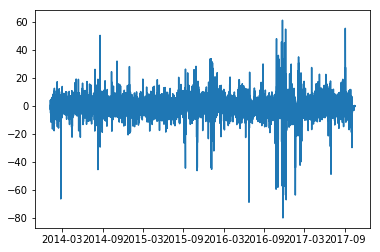

In [24]:
plt.plot(error)

In [25]:
# c) predict
D_tilde = RF.predict(_W)

# a) fitting model
L_tmp = _X - D_tilde

features, target, moments = transformer.preprocess_data(L_tmp)

# important with reshape for performance!
lstm_pred = np.array(lstm.predict(features), dtype='float64').reshape(-1)

L_tilde = (lstm_pred * moments['dist']) + moments['mean']

### STEP 3 - VALIDATION ###

# autocorrelation of errors

#have to subset len of sequence
error = transformer.calc_error(_X, D_tilde, L_tilde)

L_tilde = transformer.L_tilde_pad(L_tilde)
mse_true = np.mean(error**2)
param, conf_int_low, conf_int_high = error_autocorrelation(np.array(error))

lstm_test_res = [mse_true, param, conf_int_low, conf_int_high]

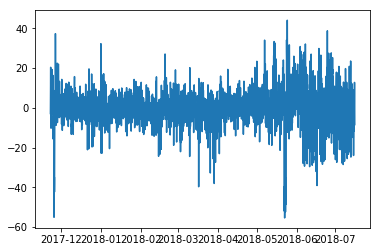

In [26]:
plt.plot(error)

In [27]:
lstm_test_res

[74.09931744843435, 0.7423038822615882, 0.7248237724381936, 0.7597839920849827]